# **Geological facies connectivity and upscaling in reservoir simulation for production forecasts optimization**
## __2D Results__


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.special import erf

from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import NullFormatter
from matplotlib.ticker import StrMethodFormatter

import os

conDir = ['./2d/2dcon_128/', './2d/2dint_128/', './2d/2ddis_128/']
varDir = ['0.5/', '1/', '2/']
stCon = ['HCS', 'ICS', 'LCS']

nseeds = 128
lc = 16
con = [2, 1, 3]
varSim = [0.5, 1, 2] 
scales = np.array([1,2,4,8,16,32,64,128,256,512,1024]) 
scaleAtt = np.linspace(1,1024,1000)

linestyle = ['dashed', 'dotted', 'dashdot']
marker = ['^', 'o', 's', '^']
color = ['red', 'darkgreen', 'navy']
color_grey = ['grey', 'dimgrey', 'black']

## __Fine grid values calculation__
<ul>
<li>Arithmetic mean</li>
<li>Geometric mean</li>
<li>Variance</li>
</ul>

In [3]:
def calculate_grid_statistics(conDir, varDir, nseeds):
    """Calculate statistics for fine grid values across different connectivity structures and variances."""
    
    k_FG = np.zeros((len(conDir), len(varDir)))
    kg_FG = np.zeros((len(conDir), len(varDir)))
    var_FG = np.zeros((len(conDir), len(varDir)))
    
    for icon, rdir1 in enumerate(conDir):
        for ivar, rdir2 in enumerate(varDir):
            values = []
            for iseed in range(nseeds):
                try:
                    filepath = f"{rdir1}{rdir2}{iseed}/k.npy"
                    aux = np.load(filepath).reshape(-1)
                    if len(aux) > 0:
                        values.append(aux)
                except Exception as e:
                    print(f"Warning: Error processing {filepath}: {e}")
                    continue
            if values:
                all_values = np.concatenate(values)
                
                k_FG[icon, ivar] = np.round(np.mean(all_values), 4)
                kg_FG[icon, ivar] = np.round(np.exp(np.mean(np.log(all_values))), 4)
                var_FG[icon, ivar] = np.round(np.var(np.log(all_values)), 4)
            else:
                print(f"Warning: No valid data for {rdir1}{rdir2}")
    return k_FG, kg_FG, var_FG

k_FG, kg_FG, var_FG = calculate_grid_statistics(conDir, varDir, nseeds)

print("\nArithmetic means:")
print(k_FG)
print("Shape:", k_FG.shape)

print("\nGeometric means:")
print(kg_FG)
print("Shape:", kg_FG.shape)

print("\nVariances:")
print(var_FG)
print("Shape:", var_FG.shape)

output_dir = "2D_data"
os.makedirs(output_dir, exist_ok=True)

# Save statistics to NPZ file
"""The .npz format is more efficient for storing multiple NumPy arrays 
in a single compressed file. Each array is saved with a different key."""

np.savez(os.path.join(output_dir, '2D_fine_grid_stat.npz'), 
         arithmetic_mean=k_FG,
         geometric_mean=kg_FG, 
         variance=var_FG)

# Save individual .npy files
#np.save(os.path.join(output_dir, 'fine_grid_ar.npy'), k_FG)
#np.save(os.path.join(output_dir, 'fine_grid_geo.npy'), kg_FG) 
#np.save(os.path.join(output_dir, 'fine_grid_var.npy'), var_FG)

print(f"\nFiles saved in {output_dir}/ directory:")
print("- fine_grid_stat.npz")
print("- ffine_grid_ar.npy")
print("- fine_grid_geo.npy")
print("- fine_grid_var.npy")


Arithmetic means:
[[1.288  1.6554 2.732 ]
 [1.2839 1.648  2.7169]
 [1.279  1.64   2.7009]]
Shape: (3, 3)

Geometric means:
[[1.0037 1.0053 1.0075]
 [1.0007 1.001  1.0014]
 [0.9963 0.9947 0.9926]]
Shape: (3, 3)

Variances:
[[0.4991 0.9981 1.9963]
 [0.4979 0.9959 1.9918]
 [0.4991 0.9981 1.9963]]
Shape: (3, 3)

Files saved in 2D_data/ directory:
- fine_grid_stat.npz
- ffine_grid_ar.npy
- fine_grid_geo.npy
- fine_grid_var.npy


## __Analytical functions definition__
### From Eberhard et al., 2006.

#### a. Equivalent hydraulic conductivity as a function of coarsening scale
$$ \ \left \langle K_{eq} \right \rangle  \left ( \lambda \right ) = \left \langle Y \right \rangle exp\left \{ -\frac{\sigma _{Y}^{2}}{D}+\frac{\sigma _{Y}^{2}}{D} \left [erf\left ( \frac{Ia_{s}}{\sqrt{2}\lambda } \right )  \right ]^{D}  \right \} $$

#### b. Variance of log of equivalent hydraulic conductivity as a function of coarsening scale
$$ \ \sigma_{log\left ( K_{eq} \right )}^{2}  \left ( \lambda \right ) =  K_{g}^{2} + \sigma _{Y}^{2} \left [erf\left ( \frac{Ia_{s}}{\sqrt{2}\lambda } \right )  \right ]^{D}  $$

In [2]:
### Analytical functions ###
#a
def attinger_amean(variance, scale, a, lc, Kg): 
    keff_scale = Kg * np.exp((variance/2)*(erf((lc*a)/(np.sqrt(2)*scale)))**2)
    return keff_scale

#b
"""Attinger (Eq. 3.2.3, Boschan & Noetinger 2012)"""
def attinger_var(variance, scale, a, lc, Kg): 
    var_scale = Kg**2 * variance * (erf ((lc*a)/(np.sqrt(2)*scale)))**2
    return var_scale

## __2D Geometric mean as a function of &lambda;/I__

/tmp/ipykernel_728089/2602691045.py:45: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


Plot saved as 2D_plots/2D_geometric_mean.png


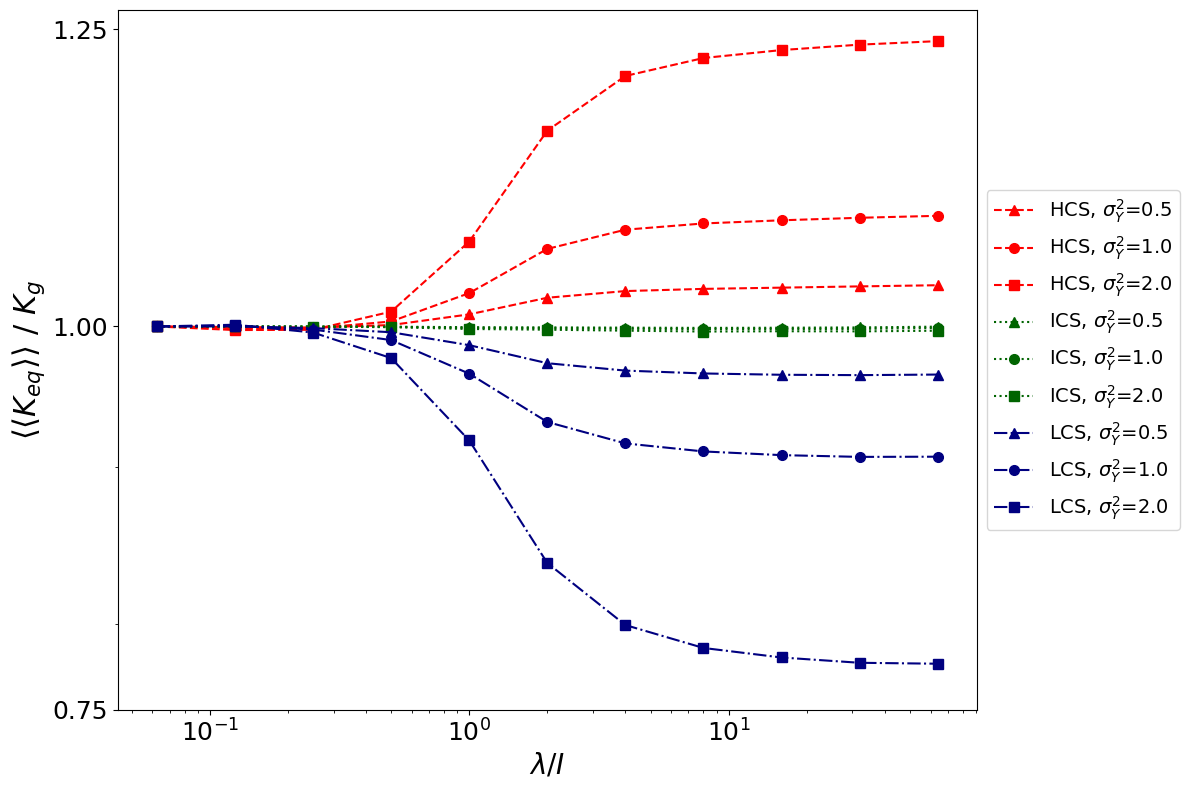

In [ ]:
### 2D Geometric mean - Plot from saved data ###

def plot_geometric_mean_from_data():
    """Plot geometric mean data from saved NPZ file"""
    
    data_path = "2D_data/2D_geometric_mean_data.npz"
    try:
        data = np.load(data_path)
        scales = data['scales']
        normalized_keff = data['normalized_keff']
        stCon = data['connectivity_structures']
        varSim = data['variances']
        lc = data['lc']
    except Exception as e:
        print(f"Error loading data from {data_path}: {e}")
        return

    fig, ax = plt.subplots(figsize=(12, 8), layout="constrained")
    
    color = ['red', 'darkgreen', 'navy']
    marker = ['^', 'o', 's']
    linestyle = ['dashed', 'dotted', 'dashdot']

    # Plot data
    for icon in range(len(stCon)):
        for ivar in range(len(varSim)):
            ax.loglog(scales/lc, normalized_keff[icon, ivar, :],
                     label=f"{stCon[icon]}, " + r"$\sigma^2_{Y}$" + f"={varSim[ivar]}",
                     color=color[icon],
                     marker=marker[ivar],
                     markersize=7,
                     fillstyle='full',
                     linewidth=1.5,
                     linestyle=linestyle[icon])

    ax.set_xlabel(r'$\lambda / I$', fontsize=20)
    ax.set_ylabel(r'$⟨⟨K_{eq}⟩⟩ \ / \ K_{g}$', fontsize=22)
    ax.get_yaxis().set_major_formatter(ScalarFormatter())
    ax.yaxis.set_minor_formatter(NullFormatter())
    ax.set_yticks(np.arange(0.75, 1.5, 0.25))
    ax.set_yticklabels([f"{x:.2f}" for x in np.arange(0.75, 1.5, 0.25)])
    ax.tick_params(axis='both', labelsize=18)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14)
    
    plt.tight_layout()

    plot_path = os.path.join("2D_plots/2D_geometric_mean.png")
    plt.savefig(plot_path, format='png', dpi=150, bbox_inches='tight')
    print(f"Plot saved as {plot_path}")

    plt.show()
    plt.close()
plot_geometric_mean_from_data()

__Fig. 4__: ⟨⟨Keq⟩⟩ / Kg as a function of $\lambda$ / l for HCS, ICS and LCS in 2D. Input variance: (△) $\sigma$(Y)=0.5, (〇) $\sigma$(Y)=1 and (◻) $\sigma$(Y)=2. 

## __2D Arithmetic mean as a function of &lambda;/I__

In [ ]:
### Arithmetic mean - Plot from saved data ###

def plot_arithmetic_mean_from_data():
    plots_dir = "2D_plots"
    #if not os.path.exists(plots_dir):
    os.makedirs(plots_dir, exist_ok=True)
    
    data_path = "2D_data/2D_arithmetic_mean_data.npz"
    try:
        data = np.load(data_path)
        scales = data['scales']
        scale_att = data['scale_att'] 
        keff = data['keff']
        norm_keff = data['normalized_keff']
        analytical = data['analytical_prediction']
        structures = data['connectivity_structures']
        variances = data['variances']
        lc = data['lc']
    except Exception as e:
        print(f"Error loading data from {data_path}: {e}")
        return

    fig, ax = plt.subplots(1, 3, layout="constrained", sharey=True, figsize=(16, 6))
    
    color = ['red', 'darkgreen', 'navy']
    marker = ['^', 'o', 's']
    num = ['a', 'b', 'c']
    linestyle = ['--', '-.', ':']
    stCon = ['High Connectivity \nStructure', 'Intermediate Connectivity \nStructure', 'Low Connectivity \nStructure']

    for icon in range(len(structures)):
        for ivar in range(len(variances)):
            # Plot experimental data
            ax[icon].loglog(scales/lc, norm_keff[icon, ivar],
                          label=r'$\sigma^2_{Y}$'+f' = {variances[ivar]}',
                          color=color[icon],
                          marker=marker[ivar],
                          markersize=6,
                          fillstyle='full',
                          linewidth=0.75,
                          linestyle='-')
            
            # Plot analytical prediction for ICS
            if icon == 1:
                ax[icon].loglog(scale_att/lc, analytical[icon, ivar],
                              label=r'Analytical: $\sigma^2_{Y}$'+f' = {variances[ivar]}',
                              color='black',
                              linewidth=1.5,
                              linestyle=linestyle[ivar])

        ax[icon].set_xlabel(r'$\lambda / I$', fontsize=20)
        if icon == 0:
            ax[icon].set_ylabel(r'$⟨K_{eq}⟩ \ / \ K_{g}$', fontsize=20)
        
        ax[icon].get_yaxis().set_major_formatter(ScalarFormatter())
        ax[icon].yaxis.set_minor_formatter(NullFormatter())
        ax[icon].set_yticks(np.arange(0.75, 3, 0.25))
        ax[icon].set_yticklabels([f"{x:.2f}" for x in np.arange(0.75, 3, 0.25)])
        ax[icon].hlines(1, 0, 64, linestyle=':', color='black', linewidth=1.25)
        #ax[icon].set_title(stCon[icon], color=color[icon], fontsize=18, loc='left', weight='bold')
        ax[icon].text(60, 2.65, num[icon], style='normal', fontsize=14)
        ax[icon].tick_params(axis='both', labelsize=14)
        ax[icon].legend(fontsize=11)
        ax[icon].grid(True, which='both', linestyle='--', alpha=0.5)

    #plt.suptitle("2D", fontsize=22, weight='bold')
    plt.tight_layout()
    
    plot_path = os.path.join(plots_dir, "2D_arithmetic_mean.png")
    plt.savefig(plot_path, format='png', dpi=300, bbox_inches='tight')
    print(f"Plot saved as {plot_path}")
    
    plt.show()
    plt.close()

plot_arithmetic_mean_from_data()

__Fig. 5__: 2D ⟨Keq⟩ / Kg as a function of $\lambda$ / l for (a) HCS, (b) ICS and (c) LCS. Input variances: (△) $\sigma$(Y)=0.5, (⭘) $\sigma$(Y)=1 and (◻) $\sigma$(Y)=2. (---) (b): analytical prediction given by Eberhard et al., 2006 using D=2 and as=1.3.

## __2D Probability density functions (PDF)__

In [ ]:
### Probability density function - Plot from saved data ###

def plot_pdfs_from_saved_data():
    """Load and plot probability density functions from saved histogram data."""
    
    data_path = "2D_data/2D_pdf_histogram_data.npz"
    try:
        data = np.load(data_path, allow_pickle=True)
        hist_data = data['histogram_data']
        stCon = data['connectivity']
        varDir = data['variances'] 
        scalesHist = data['scales']
    except Exception as e:
        print(f"Error loading data from {data_path}: {e}")
        return

    scale_col = [
        ["rosybrown", "lightcoral", "indianred", "red", "sienna", "darkred"],
        ["turquoise", "springgreen", "mediumseagreen", "lime", "green", "darkslategrey"],
        ["lightblue", "lightskyblue", "deepskyblue", "steelblue", "blue", "navy"]
    ]
    
    num = [['a','b','c'], ['d','e','f'], ['g','h','i']]
    xlim = ([-2, 2], [-3, 3], [-4, 4])
    xnum = [-1.9, -2.85, -3.8]
    ynum = [2.45, 1.65, 1.175]


    for ivar, var_data in enumerate(hist_data):
        var_value = float(varDir[ivar].rstrip('/'))
        fig, ax = plt.subplots(1, 3, sharey=True, layout='constrained', figsize=(15, 5))
        for icon, con_data in enumerate(var_data):
            for scale_data in con_data:
                scale = scale_data['scale']
                iscale = np.where(scalesHist == scale)[0][0]
                
                ax[icon].stairs(
                    scale_data['counts'],
                    scale_data['bins'],
                    label=f'λ={scale}',
                    linewidth=2,
                    color=scale_col[icon][iscale]
                )
                
            ax[icon].set_xlabel(r'$log(K_{eq})$', fontsize=20)
            if icon == 0:
                ax[icon].set_ylabel(r'$P[log(K_{eq})]$', fontsize=20)
            ax[icon].tick_params(axis='both', labelsize=14)
            ax[icon].set_xlim(xlim[ivar])
            ax[icon].legend(fontsize=12, frameon=True, loc='center left')
            ax[icon].text(xnum[ivar], ynum[ivar], num[ivar][icon], 
                         style='normal', fontsize=18)
            ax[icon].grid(True, which='both', linestyle='--', alpha=0.5)

        plt.suptitle(f"Variance = {var_value}", fontsize=16)
        plt.tight_layout()

        plot_path = os.path.join("2D_plots", f"2D_pdf_variance_{var_value:.1f}_from_data.png")
        plt.savefig(plot_path, format='png', dpi=300, bbox_inches='tight')
        print(f"Plot saved as {plot_path}")
        
        plt.show()
        plt.close()

plot_pdfs_from_saved_data()

__Fig. 6__: 2D probability density function P[log(Keq)] for the (a, d, g) high, (b, e, h) intermediate and (c, f, i) low connectivity structures. Input variance (a, b, c) $\sigma$(Y)=0.5, (d, e, f) $\sigma$(Y)=1 and (g, h, i) $\sigma$(Y)=2.

## __PDF reflections__

In [ ]:
def plot_pdf_reflections_from_data():
    """Load and plot PDF reflections from saved data with identical styling."""
    
    plots_dir = "2D_plots"
    data_dir = "2D_data" 


    try:
        # Load the saved data
        data_path = os.path.join(data_dir, "2D_pdf_reflections_data.npz")
        data = np.load(data_path, allow_pickle=True)
        
        # Extract data
        scales = data['scales']
        structures = data['structures']
        histogram_data = data['histogram_data']

        # Create figure with identical layout
        fig = plt.figure(figsize=(12, 8))
        gs = fig.add_gridspec(1, 2, width_ratios=[3, 1])
        
        ax1 = fig.add_subplot(gs[0])
        legend_ax = fig.add_subplot(gs[1])
        legend_ax.axis('off')
        
        ax2 = ax1.twiny()

        # Define colors
        scale_col_HCS = ["indianred", "red"]
        scale_col_LCS = ["blue", "darkblue"]
        
        # Store handles for legends
        hcs_handles = []
        lcs_handles = []

        # Plot HCS data
        for i, scale_data in enumerate(histogram_data[0]):  # HCS data
            h = ax1.plot(
                scale_data['hist_centers'],
                scale_data['hist_counts'],
                label=f'λ={scale_data["scale"]}, HCS',
                linewidth=2.5,
                color=scale_col_HCS[i]
            )
            hcs_handles.append(h[0])

        # Plot LCS data  
        for i, scale_data in enumerate(histogram_data[1]):  # LCS data
            h = ax2.plot(
                scale_data['hist_centers'],
                scale_data['hist_counts'], 
                label=f'λ={scale_data["scale"]}, LCS, Inv.',
                linewidth=2.0,
                color=scale_col_LCS[i]
            )
            lcs_handles.append(h[0])

        # Set axis limits and labels
        ax1.set_xlim(-2, 2)
        ax2.set_xlim(-2, 2)
        ax2.invert_xaxis()
        
        ax1.set_xlabel('$log(K_{eq})$, HCS', fontsize=14)
        ax2.set_xlabel('$log(K_{eq})$, LCS', fontsize=14)
        ax1.set_ylabel('$P[log(K_{eq})]$', fontsize=14)
        
        # Create legends
        hcs_legend = legend_ax.legend(hcs_handles,
                                   [h.get_label() for h in hcs_handles],
                                   title='HCS',
                                   loc='lower left', 
                                   fontsize=10)
        legend_ax.add_artist(hcs_legend)
        
        lcs_legend = legend_ax.legend(lcs_handles,
                                   [h.get_label() for h in lcs_handles],
                                   title='LCS',
                                   loc='upper left',
                                   fontsize=10)

        plt.suptitle('PDF Comparison: HCS vs LCS\n' + r'$\sigma^2_Y = 0.5$', fontsize=14)
        plt.tight_layout()

        # Save plot
        plot_path = os.path.join(plots_dir, "2D_pdf_reflections_from_data.png")
        plt.savefig(plot_path, format='png', dpi=100, bbox_inches='tight')
        print(f"Plot saved as {plot_path}")

        plt.show()
        plt.close()

    except Exception as e:
        print(f"Error loading or plotting data: {e}")

# Call the function 
plot_pdf_reflections_from_data()

## __Skewness comparison__

In [ ]:
### Skewness comparison - Plot from saved data ###

def plot_pdf_skewness_from_data():
    """ Load and plot PDF skewness comparison from saved data. """
    
    data_path = "2D_data/2D_pdf_skewness_data.npz"
    try:
        data = np.load(data_path, allow_pickle=True)
        variance_values = data['variance_values']
        pdf_values = data['pdf_values']
        statistics = data['statistics']
        xTheo = data['xTheo']
    except Exception as e:
        print(f"Error loading data from {data_path}: {e}")
        return

    color = ['darkgreen', 'red', 'navy']
    xlim_sk = ([-2, 2], [-4, 4])
    ylim_sk = ([0, 1], [0, 0.5])
    
    fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharey=False, layout='constrained')
    
    for ivar, var_stats in enumerate(statistics):
        var_value = var_stats['variance']
        
        for icon, struct_data in enumerate(var_stats['data']):
            ax[ivar].hist(struct_data['log_keff'],
                         bins='scott',
                         density=True,
                         histtype='step',
                         label=struct_data['connectivity'],
                         linewidth=1.5,
                         color=color[icon])
        
        ax[ivar].plot(xTheo, pdf_values[ivar],
                     color='black',
                     linewidth=2,
                     label='PDF fit',
                     linestyle='-')
        
        ax[ivar].set_xlabel(r'$log(K_{eq})$', fontsize=22)
        if ivar == 0:
            ax[ivar].set_ylabel(r'$P[log(K_{eq})]$', fontsize=22)
        ax[ivar].tick_params(axis='both', labelsize=20)
        ax[ivar].set_xlim(xlim_sk[ivar])
        #ax[ivar].set_ylim(ylim_sk[ivar])
        ax[ivar].legend(fontsize=12)
        
        label_x = -1.92 if ivar == 0 else -3.85
        label_y = 0.91 if ivar == 0 else 0.44
        ax[ivar].text(label_x, label_y, 'ab'[ivar],
                     style='normal', fontsize=22)

        ax[ivar].grid(True, which='both', linestyle='--', alpha=0.5)


    plt.suptitle('PDF Skewness Comparison\n' + 
                 r'$\sigma^2_Y = 0.5$ (left) and $\sigma^2_Y = 2.0$ (right)',
                 fontsize=16)
    
    plt.tight_layout()
    
    plots_dir = "2D_plots"
    plot_path = os.path.join(plots_dir, "2D_pdf_skewness_from_data.png") 
    plt.savefig(plot_path, format='png', dpi=300, bbox_inches='tight')
    print(f"Plot saved as {plot_path}")
    
    plt.show()
    plt.close()

plot_pdf_skewness_from_data()

## __Skewness, 3rd gaussian moment__

In [ ]:
### Skewness comparison - Plot from saved data ###

def plot_skewness_from_data():
    plots_dir = "2D_plots"
    data_path = "2D_data/2D_skewness_data.npz"
    try:
        data = np.load(data_path)
        scales = data['scales']
        skewness = data['skewness']
        structures = data['connectivity_structures']
        variances = data['variances']
        lc = data['lc']
    except Exception as e:
        print(f"Error loading data from {data_path}: {e}")
        return

    color = ['red', 'darkgreen', 'navy']
    marker_skew = ['^', 'o', 's']  
    markerfill = ['full', 'none', 'top']  
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    for icon, struct in enumerate(structures):
        for ivar, var in enumerate(variances):
            label = f"{struct}, " + r"$\sigma^2_{Y}$" + f"={var}"
            ax.semilogx(scales/lc, skewness[icon, ivar, :],
                       color=color[icon],
                       marker=marker_skew[ivar],
                       markersize=8,
                       fillstyle=markerfill[ivar],
                       label=label,
                       linestyle='none')

    ax.hlines(0, 0.1, 64, linestyle='--', color='black', 
             linewidth=1, label='Zero skewness')
    ax.hlines([-0.865, 0.865], 0.1, 64, linestyle='--', 
             color='gray', linewidth=1, label='±0.865 threshold')
    
    ax.set_xlabel(r'$\lambda / I$', fontsize=20)
    ax.set_ylabel(r"$\gamma_{\log\ (K_{eq})}$", fontsize=20)
    ax.tick_params(axis='both', labelsize=16)
    ax.grid(True, which='both', linestyle=':', alpha=0.5)
    ax.legend(fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.suptitle('Skewness Analysis of Log-Conductivity', fontsize=16)
    
    plt.tight_layout()
    plot_path = os.path.join(plots_dir, "2D_skewness_from_data.png")
    plt.savefig(plot_path, format='png', dpi=300, bbox_inches='tight')
    print(f"Plot saved as {plot_path}")
    
    plt.show()
    plt.close()

plot_skewness_from_data()

__Fig. 7__: Skewness of P[log(Keq)] as a function of $\lambda$ / l for (a) ICS, (b) HCS and (c) LCS. Input variance: (△, bottom fill)  $\sigma$(Y)=0.5, (⭘, left fill)  $\sigma$(Y)=1 and (◻, right fill)  $\sigma$(Y)=2. It shows a clear collapse for all $\sigma$(Y) for each connectivity structure. The $\gamma$[log(Keq)] values for ECI are close to zero, while for HCS are negatives with a minimum on $\lambda$ / l=1 and for LCS are positives with a maximum on $\lambda$ / l=1.

## __Normalized variance and Collapse__

In [ ]:
def plot_individual_normalized_variance_from_data():
    plots_dir = "2D_plots"
    data_path = "2D_data/2D_normalized_variance_data.npz"
    try:
        data = np.load(data_path)
        scales = data['scales']
        scale_att = data['scale_att']
        normalized_variance = data['normalized_variance']
        analytical_prediction = data['analytical_prediction'] 
        structures = data['connectivity_structures']
        variances = data['variances']
        lc = data['lc']
    except Exception as e:
        print(f"Error loading data from {data_path}: {e}")
        return
        
    color = ['red', 'darkgreen', 'navy']
    marker = ['^', 'o', 's']
    linestyle = ['dashed', 'dotted', 'dashdot']
    num = ['a', 'b', 'c']
    
    fig, ax = plt.subplots(1, 3, sharey=True, figsize=(20, 6), layout='constrained')
    
    for icon, struct in enumerate(structures):
        for ivar, var in enumerate(variances):
            ax[icon].loglog(scales/lc, normalized_variance[icon, ivar, :],
                         color=color[icon],
                         marker=marker[ivar],
                         linestyle=linestyle[icon],
                         linewidth=2.5,
                         markersize=10,
                         fillstyle='full',
                         label=r'$\sigma^2_{Y}$' + f' = {var}')
            
        ax[icon].loglog(scale_att/lc, analytical_prediction[icon, ivar, :],
                      label='Analytical',
                      color='black',
                      linewidth=1.3,
                      linestyle='-')
            
        ax[icon].set_xlabel(r'$\lambda / I$', fontsize=20)
        if icon == 0:
            ax[icon].set_ylabel(r"$(\lambda / l)^2\sigma^2_{\log\ K_{eq}}\ /\ \sigma^2_{\log\ K}$",
                             fontsize=20)
        ax[icon].tick_params(axis='both', labelsize=16)
        ax[icon].text(0.055, 1.15, num[icon], style='normal', fontsize=22)
        ax[icon].legend(fontsize=12)
        ax[icon].grid(True, which='both', linestyle='--', alpha=0.7)
        ax[icon].set_title(f"{structures[icon]}", fontsize=16)
    
    plt.tight_layout()
    
    plot_path = os.path.join(plots_dir, "2D_individual_normalized_variance.png")
    plt.savefig(plot_path, format='png', dpi=300, bbox_inches='tight')
    print(f"Individual plots saved as {plot_path}")
    
    plt.show()
    plt.close()

def plot_collapsed_normalized_variance_from_data():
    data_path = "2D_data/2D_normalized_variance_data.npz"
    plots_dir = "2D_plots"
    try:
        data = np.load(data_path)
        scales = data['scales']
        scale_att = data['scale_att']
        normalized_variance = data['normalized_variance']
        analytical_prediction = data['analytical_prediction'] 
        structures = data['connectivity_structures']
        variances = data['variances']
        lc = data['lc']
    except Exception as e:
        print(f"Error loading data from {data_path}: {e}")
        return
        
    color = ['red', 'darkgreen', 'navy']
    marker = ['^', 'o', 's']
    linestyle = ['dashed', 'dotted', 'dashdot']
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    for icon, struct in enumerate(structures):
        for ivar, var in enumerate(variances):
            ax.loglog(scales/lc, normalized_variance[icon, ivar, :],
                     color=color[icon],
                     marker=marker[ivar],
                     linestyle=linestyle[icon],
                     linewidth=2,
                     markersize=8,
                     fillstyle='full',
                     label=f"{struct}, " + r"$\sigma^2_{Y}$" + f"= {var}")
    
    ax.loglog(scale_att/lc, analytical_prediction[1, 1, :],
             color='black',
             linewidth=1,
             linestyle='-',
             label='Analytical')
    
    ax.set_xlabel(r'$\lambda / I$', fontsize=20)
    ax.set_ylabel(r"$(\lambda / l)^2\sigma^2_{\log\ K_{eq}}\ /\ \sigma^2_{\log\ K}$",
                 fontsize=20)
    ax.tick_params(axis='both', labelsize=16)
    ax.grid(True, which='both', linestyle='--', alpha=0.7)
    ax.legend(fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.suptitle('Collapse of Normalized Variances', fontsize=16)
    plt.tight_layout()
    
    plot_path = os.path.join(plots_dir, "2D_collapsed_normalized_variance.png")
    plt.savefig(plot_path, format='png', dpi=300, bbox_inches='tight')
    print(f"Collapse plot saved as {plot_path}")
    
    plt.show()
    plt.close()

plot_individual_normalized_variance_from_data()
plot_collapsed_normalized_variance_from_data()

__Fig. 8a__: $(\lambda /l)^{2}\sigma[log(Keq)]/\sigma (Y)$  as a function of $\lambda$/l for (a) (. . .) HCS, (b) (- - -) ICS and (c)  (- . -) LCS for 2D media samples. Input variance: (△) $\sigma$(Y)=0.5, (〇) $\sigma$(Y)=1 and (◻) $\sigma$(Y)=2. The numerical experiments are compared with (___) analytical results based on Eberhard et al., 2006 equations where D=2 and as=1.3.

__Fig. 8b__:Collapse of normalized variances for (. . .) HCS, (- - -) ICS and (- . -) LCS for all input log conductivity variances: (△) $\sigma$(Y)=0.5, (〇) $\sigma$(Y)=1 and (◻) $\sigma$(Y)=2 compared with (___) analytical results based on Eberhard et al., 2006 equationswhere D=2 and as=1.3.